<a href="https://colab.research.google.com/github/arman10pourmoghim/cifar10-pytorch-cnn/blob/main/CNN_on_CIFAR_10.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
import torch
from torch.utils.data import DataLoader, random_split
from torchvision import datasets, transforms
from torch import nn, optim
from torch.optim.lr_scheduler import CosineAnnealingLR
import torchvision
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import confusion_matrix
import copy

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print("Using device:", device)

Using device: cuda


In [2]:
# Common normalization values for CIFAR-10
cifar10_mean = (0.4914, 0.4822, 0.4465)
cifar10_std  = (0.2470, 0.2435, 0.2616)

train_transform = transforms.Compose([
    transforms.RandomHorizontalFlip(),
    transforms.RandomCrop(32, padding = 4),
    transforms.ToTensor(),
    transforms.Normalize(cifar10_mean, cifar10_std)
])

test_transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize(cifar10_mean, cifar10_std)
])

In [3]:
train_dataset_full = datasets.CIFAR10(
    root = "data",
    train = True,
    download = True,
    transform = None
)

test_dataset = datasets.CIFAR10(
    root = "data",
    train = False,
    download = True,
    transform = test_transform
)

100%|██████████| 170M/170M [00:13<00:00, 12.4MB/s]


In [4]:
train_size = int(0.9 * len(train_dataset_full))
val_size = len(train_dataset_full) - train_size

train_dataset, val_dataset = random_split(
    train_dataset_full,
    [train_size, val_size],
    generator = torch.Generator().manual_seed(42)
)

# Assign transforms explicitly and safely
train_dataset.dataset.transform = train_transform
val_dataset.dataset.transform   = test_transform

In [5]:
batch_size = 128

train_loader = DataLoader(
    train_dataset,
    batch_size = batch_size,
    shuffle = True,
    num_workers = 2,
    pin_memory = True
)

val_loader = DataLoader(
    val_dataset,
    batch_size = batch_size,
    shuffle = False,
    num_workers = 2,
    pin_memory = True
)

test_loader = DataLoader(
    test_dataset,
    batch_size = batch_size,
    shuffle = False,
    num_workers = 2,
    pin_memory = True
)

In [6]:
images, labels = next(iter(train_loader))
print("Batch image shape:", images.shape)
print("Batch label shape:", labels.shape)

Batch image shape: torch.Size([128, 3, 32, 32])
Batch label shape: torch.Size([128])


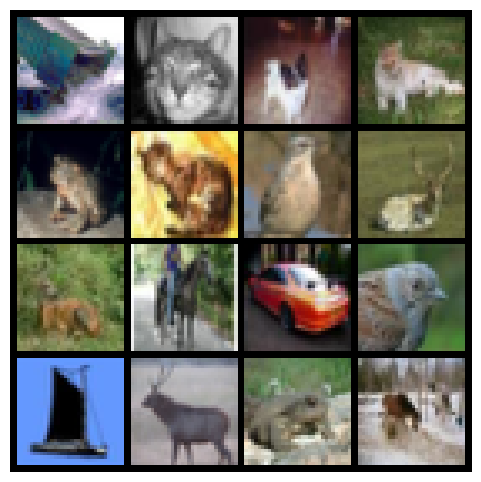

In [7]:
def unnormalize(img):
  for c, m, s in zip(img, cifar10_mean, cifar10_std):
    img = img.clone()
  return img * torch.tensor(cifar10_std).view(3, 1, 1) + torch.tensor(cifar10_mean).view(3, 1, 1)

imgs = images[: 16]
imgs = torch.stack([unnormalize(img) for img in imgs])

grid = torchvision.utils.make_grid(imgs, nrow = 4)
plt.figure(figsize = (6, 6))
plt.imshow(grid.permute(1, 2, 0))
plt.axis("off")
plt.show()

In [8]:
class SimpleCNN(nn.Module):
  def __init__(self, num_classes: int = 10):
    super().__init__()

    self.features = nn.Sequential(
        # input = [B, 3, 32, 32]
        nn.Conv2d(in_channels = 3, out_channels = 32, kernel_size = 3, padding = 1),
        nn.ReLU(inplace = True),
        nn.MaxPool2d(kernel_size = 2, stride = 2),

        # --> = [B, 32, 16, 16]
        nn.Conv2d(in_channels = 32, out_channels = 64, kernel_size = 3, padding = 1),
        nn.ReLU(inplace = True),
        nn.MaxPool2d(kernel_size = 2, stride = 2)
    )

    self.classifier = nn.Sequential(
        # --> = [B, 64, 8, 8]
        nn.Flatten(),
        # --> = [B, 64 * 8 * 8]
        nn.Linear(64 * 8 * 8, 128),
        nn.ReLU(inplace = True),
        nn.Linear(128, num_classes)
    )

  def forward(self, x: torch.Tensor) -> torch.Tensor:
    x = self.features(x)
    x = self.classifier(x)
    return x

In [9]:
model = SimpleCNN(num_classes = 10)
model = model.to(device)

images, labels = next(iter(train_loader))
images = images.to(device)
labels = labels.to(device)

with torch.no_grad():
  outputs = model(images)

print("Input shape:", images.shape)
print("Output shape:", outputs.shape)

Input shape: torch.Size([128, 3, 32, 32])
Output shape: torch.Size([128, 10])


In [10]:
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr = 1e-3)

In [11]:
def train_one_epoch(model, dataloader, optimizer, criterion, device):
  model.train()
  running_loss = 0
  correct = 0
  total = 0

  for images, labels in dataloader:
    images, labels = images.to(device), labels.to(device)

    outputs = model(images)
    loss = criterion(outputs, labels)

    optimizer.zero_grad()
    loss.backward()
    optimizer.step()

    running_loss += loss.item() * images.size(0)

    _, preds = outputs.max(1)
    correct += preds.eq(labels).sum().item()
    total += labels.size(0)

  epoch_loss = running_loss / len(dataloader.dataset)
  epoch_acc = correct / total

  return epoch_loss, epoch_acc

In [12]:
def evaluate(model, dataloader, criterion, device):
  model.eval()
  running_loss = 0
  correct = 0
  total = 0

  with torch.no_grad():
    for images, labels in dataloader:
      images, labels = images.to(device), labels.to(device)

      outputs = model(images)
      loss = criterion(outputs, labels)

      running_loss += loss.item() * images.size(0)
      _, preds = outputs.max(1)
      correct += preds.eq(labels).sum().item()
      total += labels.size(0)

    epoch_loss = running_loss / len(dataloader.dataset)
    epoch_acc = correct / total

    return epoch_loss, epoch_acc

In [13]:
num_epochs = 10

for epoch in range(num_epochs):
  train_loss, train_acc = train_one_epoch(model, train_loader, optimizer, criterion, device)
  val_loss, val_acc = evaluate(model, val_loader, criterion, device)

  print(f"Epoch {epoch + 1} / {num_epochs} | "
  f"Train Loss: {train_loss: .4f} | Train Accuracy: {train_acc: .4f} | "
  f"Validation Loss: {val_loss: .4f} | Validation Accuracy: {val_acc: .4f}")

Epoch 1 / 10 | Train Loss:  1.4019 | Train Accuracy:  0.5006 | Validation Loss:  1.1661 | Validation Accuracy:  0.5902
Epoch 2 / 10 | Train Loss:  1.0283 | Train Accuracy:  0.6368 | Validation Loss:  0.9866 | Validation Accuracy:  0.6464
Epoch 3 / 10 | Train Loss:  0.8720 | Train Accuracy:  0.6950 | Validation Loss:  0.9445 | Validation Accuracy:  0.6648
Epoch 4 / 10 | Train Loss:  0.7550 | Train Accuracy:  0.7366 | Validation Loss:  0.8647 | Validation Accuracy:  0.6958
Epoch 5 / 10 | Train Loss:  0.6575 | Train Accuracy:  0.7719 | Validation Loss:  0.8774 | Validation Accuracy:  0.7022
Epoch 6 / 10 | Train Loss:  0.5716 | Train Accuracy:  0.7997 | Validation Loss:  0.8405 | Validation Accuracy:  0.7210
Epoch 7 / 10 | Train Loss:  0.4911 | Train Accuracy:  0.8296 | Validation Loss:  0.8598 | Validation Accuracy:  0.7208
Epoch 8 / 10 | Train Loss:  0.4223 | Train Accuracy:  0.8537 | Validation Loss:  0.9287 | Validation Accuracy:  0.7148
Epoch 9 / 10 | Train Loss:  0.3485 | Train Accur

In [14]:
class_names = [
    'airplane',
    'automobile',
    'bird',
    'cat',
    'deer',
    'dog',
    'frog',
    'horse',
    'ship',
    'truck'
]

In [15]:
def get_confusion_matrix(model, dataloader, device):
  model.eval()
  all_preds = []
  all_labels = []

  with torch.no_grad():
    for images, labels in dataloader:
      images = images.to(device)
      outputs = model(images)
      _, preds = torch.max(outputs, 1)

      all_preds.append(preds.cpu().numpy())
      all_labels.append(labels.numpy())

  all_preds = np.concatenate(all_preds)
  all_labels = np.concatenate(all_labels)

  return confusion_matrix(all_labels, all_preds)

In [16]:
def plot_confusion_matrix(cm, class_names):
    plt.figure(figsize=(8,8))
    sns.heatmap(cm, annot=False, cmap="Blues", xticklabels=class_names, yticklabels=class_names)
    plt.xlabel("Predicted")
    plt.ylabel("True")
    plt.title("Confusion Matrix")
    plt.show()

In [17]:
def show_misclassified(model, dataloader, device, class_names, num_images = 8):
  model.eval()
  misclassified = []

  with torch.no_grad():
    for images, labels in dataloader:
      images = images.to(device)
      outputs = model(images)
      _, preds = torch.max(outputs, 1)

      for img, pred, true in zip(images, preds, labels):
        if pred != true:
          misclassified.append((img.cpu(), pred.item(), true.item()))
          if len(misclassified) == num_images:
            break
      if len(misclassified) == num_images:
        break

    plt.figure(figsize = (10, 5))
    for i, (img, pred, true) in enumerate(misclassified):
      plt.subplot(2, num_images // 2, i + 1)
      img = unnormalize(img)
      plt.imshow(img.permute(1,2,0))
      plt.title(f"True: {class_names[true]}\nPred: {class_names[pred]}")
      plt.axis("off")
    plt.show()

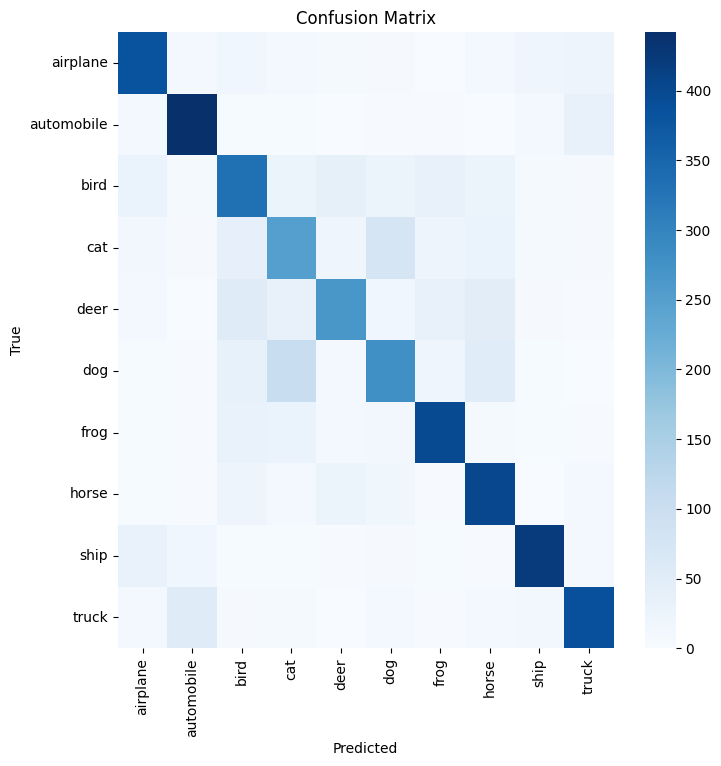

In [18]:
cm = get_confusion_matrix(model, val_loader, device)
plot_confusion_matrix(cm, class_names)

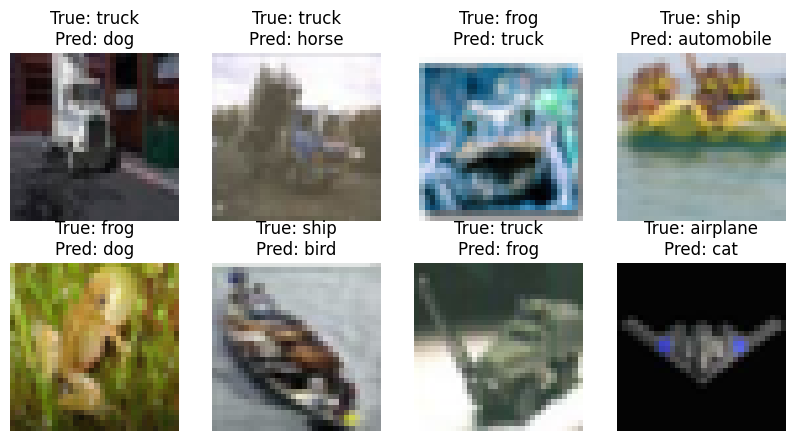

In [19]:
show_misclassified(model, val_loader, device, class_names, num_images=8)

# Regularization & Improvements

In [20]:
train_transform = transforms.Compose([
    transforms.RandomCrop(32, padding = 4),
    transforms.RandomHorizontalFlip(),
    transforms.RandomRotation(15),
    transforms.ColorJitter(
        brightness = 0.2,
        contrast = 0.2,
        saturation = 0.2,
        hue = 0.02
    ),
    transforms.ToTensor(),
    transforms.Normalize(cifar10_mean, cifar10_std),
    transforms.RandomErasing(
        p = 0.2,
        scale = (0.02, 0.2),
        ratio = (0.3, 3.3)
    )
])

In [21]:
train_dataset, val_dataset = random_split(
    train_dataset_full,
    [train_size, val_size],
    generator = torch.Generator().manual_seed(42)
)

# Assign transforms explicitly and safely
train_dataset.dataset.transform = train_transform
val_dataset.dataset.transform   = test_transform

In [22]:
class SimpleCNN(nn.Module):
  def __init__(self, num_classes = 10):
    super().__init__()

    self.features = nn.Sequential(
        nn.Conv2d(3, 32, kernel_size = 3, padding = 1),
        nn.ReLU(inplace = True),
        nn.MaxPool2d(2),

        nn.Conv2d(32, 64, kernel_size = 3, padding = 1),
        nn.ReLU(inplace = True),
        nn.MaxPool2d(2)
    )

    self.classifier = nn.Sequential(
        nn.Flatten(),

        nn.Linear(64 * 8 * 8, 256),
        nn.ReLU(inplace = True),

        nn.Dropout(p = 0.5),

        nn.Linear(256, num_classes)
    )

    def forward(self, x):
      x = self.features(x)
      x = self.classifier(x)
      return x

In [23]:
class EarlyStopping:
  def __init__(self, patience = 10, mode = "min", delta = 0):
    self.patience = patience
    self.mode = mode
    self.delta = delta
    self.best_score = None
    self.num_bad_epochs = 0
    self.should_stop = False
    self.best_state_dict = None

  def step(self, current):
    if self.best_score is None:
      self.best_score = current
      return

    if self.mode == "min":
      improvement = self.best_score - current
    else:
      improvement = current - self.best_score

    if improvement > self.delta:
      self.best_score = current
      self.num_bad_epochs = 0
    else:
      self.num_bad_epochs += 1
      if self.num_bad_epochs >= self.patience:
        self.should_stop = True

In [24]:
optimizer = optim.Adam(model.parameters(), lr = 1e-3, weight_decay = 1e-4)

In [25]:
scheduler = CosineAnnealingLR(
    optimizer,
    T_max = 10,
    eta_min = 0
)

In [26]:
num_epochs = 100
early_stopper = EarlyStopping(patience = 10, mode = "min", delta = 0)

best_model_state = copy.deepcopy(model.state_dict())

for epoch in range(num_epochs):
  train_loss, train_acc = train_one_epoch(model, train_loader, optimizer, criterion, device)
  val_loss, val_acc = evaluate(model, val_loader, criterion, device)

  scheduler.step()

  early_stopper.step(val_loss)

  if val_loss <= early_stopper.best_score:
    best_model_state = copy.deepcopy(model.state_dict())

  print(
      f"Epoch [{epoch + 1} / {num_epochs}] "
      f"Train Loss: {train_loss: .4f} | Train Accuracy: {train_acc: .4f} | "
      f"Validation Loss: {val_loss: .4f} | Validation Accuracy: {val_acc: .4f}"
  )

  if early_stopper.should_stop:
     print(f"Early stopping triggered at epoch {epoch + 1}")
     break

model.load_state_dict(best_model_state)

Epoch [1 / 100] Train Loss:  0.2455 | Train Accuracy:  0.9149 | Validation Loss:  1.1247 | Validation Accuracy:  0.7130
Epoch [2 / 100] Train Loss:  0.1833 | Train Accuracy:  0.9382 | Validation Loss:  1.1578 | Validation Accuracy:  0.7236
Epoch [3 / 100] Train Loss:  0.1422 | Train Accuracy:  0.9536 | Validation Loss:  1.3062 | Validation Accuracy:  0.7054
Epoch [4 / 100] Train Loss:  0.0999 | Train Accuracy:  0.9694 | Validation Loss:  1.3943 | Validation Accuracy:  0.7096
Epoch [5 / 100] Train Loss:  0.0583 | Train Accuracy:  0.9860 | Validation Loss:  1.5012 | Validation Accuracy:  0.7058
Epoch [6 / 100] Train Loss:  0.0361 | Train Accuracy:  0.9934 | Validation Loss:  1.5171 | Validation Accuracy:  0.7114
Epoch [7 / 100] Train Loss:  0.0190 | Train Accuracy:  0.9985 | Validation Loss:  1.5779 | Validation Accuracy:  0.7176
Epoch [8 / 100] Train Loss:  0.0124 | Train Accuracy:  0.9996 | Validation Loss:  1.6233 | Validation Accuracy:  0.7208
Epoch [9 / 100] Train Loss:  0.0098 | Tr

<All keys matched successfully>

In [27]:
test_loss, test_acc = evaluate(model, test_loader, criterion, device)
print(f"Test Loss: {test_loss:.4f} | Test Accuracy: {test_acc:.4f}")

Test Loss: 1.1620 | Test Accuracy: 0.7060
